In [1]:
#Import required libraries
import argparse
import gym
import wandb
import numpy as np
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
#Set constants for training
seed = 543 #constant
gamma = 0.99 #constant
lr_optim = 1e-3 #tunable
lr_optimV = 1e-3 #tunable
torch.manual_seed(seed)
log_interval = 10
device = torch.device("cuda:0")

In [3]:
class Network(nn.Module):
    def __init__(self,hidden_size,state_shape = 4,action_size = 2 ):
        super(Network, self).__init__()
        self.affine1 = nn.Linear(state_shape, int(hidden_size))
        self.action_head = nn.Linear(int(hidden_size), action_size)
        self.saved_actions = []
        self.episode_rewards = []
        self.episode_states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_prob = F.softmax(self.action_head(x), dim=-1)
        return action_prob


In [4]:
class VNetwork(nn.Module):
    def __init__(self, state_size, seed, fc1_units=128, fc2_units=64):
        super(VNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class REINFORCE_mcwb:

    def __init__(self,hidden,lr):
        env = gym.make('Acrobot-v1')
        self.env = env
        self.episodes = 5000
        env.reset()
        self.hidden = hidden
        state_shape = env.observation_space.shape[0]
        no_of_actions = env.action_space.n
        model = Network(hidden,state_shape,no_of_actions)
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr)
        self.max_len = 10000
        
    def select_action(self,state):
        state = torch.from_numpy(state).float()
        probs = self.model(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item()

    def update(self,rewards, states, actions):
        G = 0
        gamma = 0.99
        self.optimizer.zero_grad()
        for i in reversed(range(len(rewards))):  
            reward = rewards[i]
            state = torch.tensor(states[i].reshape(1, -1),
                                 dtype=torch.float)
            action = torch.tensor(actions[i]).view(-1, 1)
            log_prob = torch.log(self.model(state).gather(1, action))  
            G = gamma * G + reward  
            loss = -log_prob * G       
            loss.backward()             
        self.optimizer.step()
        del self.model.episode_rewards[:]
        del self.model.saved_actions[:]
        del self.model.episode_states[:]
     
    def train(self):
        total_reward = []
        avg_reward = []
        running_reward = -200
        # run infinitely many episodes
        for i_episode in range(self.episodes):
            # reset environment and episode reward
            state, _ = self.env.reset()
            self.model.episode_states.append(state)
            ep_reward = 0
            for t in range(1, self.max_len):
            # select action from policy
                action = self.select_action(state)
                state, reward, done, _, _ = self.env.step(action)
                self.model.episode_states.append(state)
                self.model.episode_rewards.append(reward)
                self.model.saved_actions.append(action)
                ep_reward += reward
                if done:
                   break 
            if ep_reward > 500 or ep_reward < -500:
                ep_reward = 500*ep_reward/abs(ep_reward)
            total_reward.append(ep_reward)
            self.update(self.model.episode_rewards, self.model.episode_states, self.model.saved_actions)   
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
            avg_reward.append(running_reward)

            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            if i_episode > 350 :
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(avg_reward)))
                break
        regret = self.regret(avg_reward)
        return regret, avg_reward, t
    
    def run(self):
        total_reward = []
        avg_reward = []
        running_reward = -200
        # run infinitely many episodes
        for i_episode in range(self.episodes):
            # reset environment and episode reward
            state, _ = self.env.reset()
            self.model.episode_states.append(state)
            ep_reward = 0
            for t in range(1, self.max_len):
            # select action from policy
                action = self.select_action(state)
                state, reward, done, _, _ = self.env.step(action)
                self.model.episode_states.append(state)
                self.model.episode_rewards.append(reward)
                self.model.saved_actions.append(action)
                ep_reward += reward
                if done:
                   break 
            if ep_reward > 500 or ep_reward < -500:
                ep_reward = 500*ep_reward/abs(ep_reward)
            total_reward.append(ep_reward)
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
            avg_reward.append(running_reward)

            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            if i_episode >350:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(avg_reward)))
                break
        regret = self.regret(avg_reward)
        return regret, avg_reward
    
    def regret(self,avg_reward):
        regret = 0
        for i in range(len(avg_reward)):
            regret += self.env.spec.reward_threshold - avg_reward[i]
        return regret
        

In [6]:
class REINFORCE_mcb:

    def __init__(self,hidden,lp,lv):
        env = gym.make("Acrobot-v1")
        self.env = env
        seed  = 543
        self.episodes = 5000
        env.reset()
        state_shape = env.observation_space.shape[0]
        no_of_actions = env.action_space.n
        policy = Network(hidden, state_shape,no_of_actions)  
        self.policy = policy
        self.optimizerP = optim.Adam(policy.parameters(), lp)
        self.vnetwork_local = VNetwork(state_shape, seed)  
        self.optimizerV = optim.Adam(self.vnetwork_local.parameters(), lv)
        self.vnetwork_target = VNetwork(state_shape, seed)  
        self.max_len = 10000

    def learn_Value(self, states, actions, rewards, next_states, dones):
        next_states = torch.tensor(next_states)  
        V_targets_next = self.vnetwork_target(next_states).detach()
        V_targets =  + (gamma * V_targets_next * (1 - dones))
        actions = torch.tensor(actions).view(-1, 1)  
        V_expected = self.vnetwork_local(torch.tensor(states)  )
        loss = F.mse_loss(V_expected, V_targets)
        self.optimizerV.zero_grad()
        loss.backward()
        for param in self.vnetwork_local.parameters():
              param.grad.data.clamp_(-1, 1)
        self.optimizerV.step()
        
    def select_action(self,state):
        state = torch.from_numpy(state).float()  
        probs = self.policy(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item()

    def update(self,rewards, states, actions):
        G = 0
        gamma = 0.99
        self.optimizerP.zero_grad()
        for i in reversed(range(len(rewards))):  
            reward = rewards[i]
            state = torch.tensor(states[i].reshape(1, -1),
                                 dtype=torch.float)  
            action = torch.tensor(actions[i]).view(-1, 1)  
            log_prob = torch.log(self.policy(state)).gather(1,action)
            #print(log_prob)
            G = gamma * G + reward
            advantage =  G  - self.vnetwork_local(state)
            #print(advantage)
            loss = -log_prob * advantage 
            loss.backward()             
        self.optimizerP.step()
        del self.policy.episode_rewards[:]
        del self.policy.saved_actions[:]
        del self.policy.episode_states[:]
     
    def train(self,reward):
        total_reward = []
        avg_reward = []
        running_reward = reward
        # run infinitely many episodes
        for i_episode in range(self.episodes):
            # reset environment and episode reward
            state, _ = self.env.reset()
            ep_reward = 0
            for t in range(1, self.max_len):
            # select action from policy
                self.policy.episode_states.append(state)
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.learn_Value(state, action, reward, next_state, done)
                self.policy.episode_rewards.append(reward)
                self.policy.saved_actions.append(action)
                state = next_state
                ep_reward += reward
                if done:
                   break
            if ep_reward > 500 or ep_reward < -500:
                ep_reward = 500*ep_reward/abs(ep_reward)
            total_reward.append(ep_reward)
            
            self.update(self.policy.episode_rewards, self.policy.episode_states, self.policy.saved_actions)   
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
            avg_reward.append(running_reward)
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            if i_episode > 350:
        
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(avg_reward)))
                break
            regret = self.regret(avg_reward)
        return regret, avg_reward, t

    def run(self,reward):
        total_reward = []
        avg_reward = []
        running_reward = reward
        # run infinitely many episodes
        for i_episode in range(self.episodes):
            # reset environment and episode reward
            state, _ = self.env.reset()
            ep_reward = 0
            for t in range(1, self.max_len):
            # select action from policy
                self.policy.episode_states.append(state)
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                #self.learn_Value(state, action, reward, next_state, done)
                self.policy.episode_rewards.append(reward)
                self.policy.saved_actions.append(action)
                state = next_state
                ep_reward += reward
                if done:
                   break
            if ep_reward > 500 or ep_reward < -500:
                ep_reward = 500*ep_reward/abs(ep_reward)
            total_reward.append(ep_reward)
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
            avg_reward.append(running_reward)
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            if  i_episode >350:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(avg_reward)))
                break
            regret = self.regret(avg_reward)
        return regret, avg_reward 

    def regret(self,avg_reward):
        regret = 0
        for i in range(len(avg_reward)):
            regret += self.env.spec.reward_threshold - avg_reward[i]
        return regret


Training and Running with tuned params

In [7]:
hidden1 = 256
hidden2 = 64
lp = 0.0007682
lv = 0.008029
lr =  0.008618
reinforce_b = REINFORCE_mcb(hidden1,lp,lv)
rb, ab, tb = reinforce_b.train(-200)

Episode 0	Last reward: -339.00	Average reward: -206.95
Episode 1	Last reward: -296.00	Average reward: -211.40
Episode 2	Last reward: -440.00	Average reward: -222.83
Episode 3	Last reward: -500.00	Average reward: -236.69
Episode 4	Last reward: -500.00	Average reward: -249.86
Episode 5	Last reward: -500.00	Average reward: -262.36
Episode 6	Last reward: -500.00	Average reward: -274.25
Episode 7	Last reward: -431.00	Average reward: -282.08
Episode 8	Last reward: -272.00	Average reward: -281.58
Episode 9	Last reward: -333.00	Average reward: -284.15
Episode 10	Last reward: -218.00	Average reward: -280.84
Episode 11	Last reward: -258.00	Average reward: -279.70
Episode 12	Last reward: -310.00	Average reward: -281.22
Episode 13	Last reward: -232.00	Average reward: -278.75
Episode 14	Last reward: -500.00	Average reward: -289.82
Episode 15	Last reward: -245.00	Average reward: -287.58
Episode 16	Last reward: -312.00	Average reward: -288.80
Episode 17	Last reward: -156.00	Average reward: -282.16
Ep

In [9]:
reinforce_w = REINFORCE_mcwb(128,lr)
rw, aw, tw = reinforce_w.train()

Episode 0	Last reward: -500.00	Average reward: -215.00
Episode 1	Last reward: -282.00	Average reward: -218.35
Episode 2	Last reward: -350.00	Average reward: -224.93
Episode 3	Last reward: -370.00	Average reward: -232.19
Episode 4	Last reward: -244.00	Average reward: -232.78
Episode 5	Last reward: -211.00	Average reward: -231.69
Episode 6	Last reward: -171.00	Average reward: -228.65
Episode 7	Last reward: -195.00	Average reward: -226.97
Episode 8	Last reward: -140.00	Average reward: -222.62
Episode 9	Last reward: -92.00	Average reward: -216.09
Episode 10	Last reward: -94.00	Average reward: -209.99
Episode 11	Last reward: -85.00	Average reward: -203.74
Episode 12	Last reward: -151.00	Average reward: -201.10
Episode 13	Last reward: -85.00	Average reward: -195.30
Episode 14	Last reward: -126.00	Average reward: -191.83
Episode 15	Last reward: -127.00	Average reward: -188.59
Episode 16	Last reward: -119.00	Average reward: -185.11
Episode 17	Last reward: -103.00	Average reward: -181.00
Episod

In [10]:
def PerformExpmt(num_expmt):
        reward_avgs = []
        for i in range(num_expmt):  
            print("Experiment: %d"%(i+1))
            regret,rewards = reinforce_b.run(-200)   
            reward_avgs.append(np.asarray(rewards))
        mean_base = np.mean(np.array(reward_avgs), axis=0)
        std_base = np.std(reward_avgs, axis=0)

        reward_avgs = []
        for i in range(num_expmt):  
            print("Experiment: %d"%(i+1))
            regret,rewards = reinforce_w.run()   
            reward_avgs.append(np.asarray(rewards))
        mean_wbase = np.mean(np.array(reward_avgs), axis=0)
        std_wbase = np.std(reward_avgs, axis=0)
        return mean_base, std_base, mean_wbase, std_wbase


mean_base, std_base, mean_wbase, std_wbase = PerformExpmt(5)



Experiment: 1
Episode 0	Last reward: -94.00	Average reward: -194.70
Episode 1	Last reward: -137.00	Average reward: -191.81
Episode 2	Last reward: -100.00	Average reward: -187.22
Episode 3	Last reward: -115.00	Average reward: -183.61
Episode 4	Last reward: -109.00	Average reward: -179.88
Episode 5	Last reward: -86.00	Average reward: -175.19
Episode 6	Last reward: -100.00	Average reward: -171.43
Episode 7	Last reward: -85.00	Average reward: -167.11
Episode 8	Last reward: -146.00	Average reward: -166.05
Episode 9	Last reward: -75.00	Average reward: -161.50
Episode 10	Last reward: -106.00	Average reward: -158.72
Episode 11	Last reward: -139.00	Average reward: -157.74
Episode 12	Last reward: -119.00	Average reward: -155.80
Episode 13	Last reward: -83.00	Average reward: -152.16
Episode 14	Last reward: -83.00	Average reward: -148.70
Episode 15	Last reward: -99.00	Average reward: -146.22
Episode 16	Last reward: -114.00	Average reward: -144.61
Episode 17	Last reward: -90.00	Average reward: -141

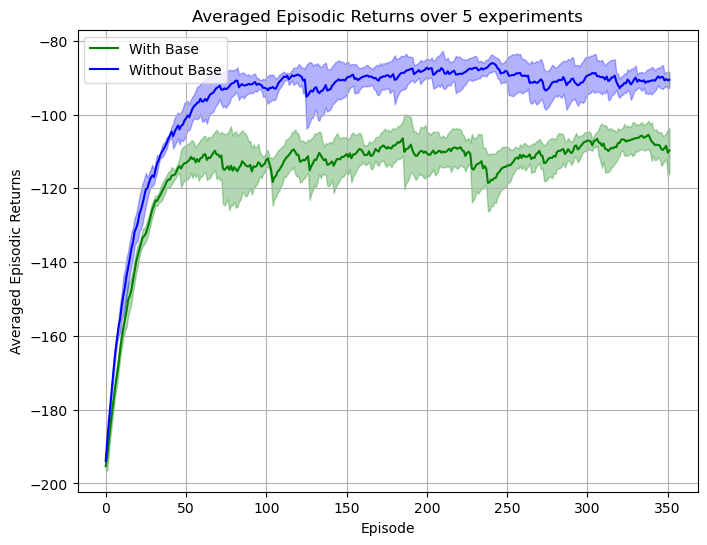

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(352), mean_base, label='With Base', color='green')
plt.fill_between(range(352), mean_base - std_base, mean_base + std_base, alpha=0.3, color='green')
plt.plot(range(352), mean_wbase, label='Without Base', color='blue')
plt.fill_between(range(352), mean_wbase - std_wbase, mean_wbase + std_wbase, alpha=0.3, color='blue')
plt.xlabel('Episode')
plt.ylabel('Averaged Episodic Returns')
plt.title("Averaged Episodic Returns over 5 experiments")
plt.legend()
plt.grid()
plt.savefig('withoutbaseline.png')
plt.show()

Tuning

In [ ]:
def tune(hidden,lp,lv):
    reinforce = REINFORCE_mcb(hidden,lp,lv)
    regret, avg_reward = reinforce.train(-10)
    return regret, avg_reward

sweep_config = {
    'method': 'bayes'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'hidden': {
        # a flat distribution between 0 and 0.1
        "values": [128, 256],
      },
      'lp': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.00001,
        'max': 0.0001
      },
      'lv': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.00001,
        'max': 0.001
      }
    }

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="with-base-acro-final")

def tuner(config=sweep_config):
    with wandb.init(config=config):
        config = wandb.config
        regret, avg_reward = tune(config.hidden,config.lp,config.lv)
        for epoch in range(len(avg_reward)):
            wandb.log({"Score": avg_reward[epoch], "epoch": epoch})
        wandb.log({"regret": regret})    

wandb.agent(sweep_id, tuner, count=7)

In [ ]:
def tune(hidden,lp,lv):
    reinforce = REINFORCE_mcb(hidden,lp,lv)
    regret, avg_reward = reinforce.train()
    return regret, avg_reward

def run_training():
    config_defaults = {
        "lp": 5e-4,
        "lv": 5e-4,
        "hidden": 64
        
    }
    config = wandb.init(config=config_defaults, project="withBaseline_acro2")
    lp = config.config["lp"]
    lv = config.config['lv']
    hidden = config.config["hidden"]
    regret, all_scores = tune(hidden,lp,lv)
    for i in all_scores:
        wandb.log({'Scores':i})
    wandb.log({"regret": regret})
    

sweep_config = {
    "method": "bayes",
    "metric": {"name": "regret", "goal": "minimize"},
    "parameters": {
        "lp": {"min": 0.001, "max": 0.1},
        "lv": {"min": 0.001, "max": 0.1},
        "hidden": {"values": [128, 256]}
        
    },
    "project": "withbase_acro_optim",
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 3,
        "max_iter": 100
    }
}

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=run_training)